# Milestone 2

In [1]:
# Install missing packages
# %pip install cpi

In [2]:
#we import all the necessary librairies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import ast
from datetime import datetime
# import cpi


# # Make sure that we have the good rate for computing the inflation
# cpi.update()


In [3]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

## 1. Data cleaning and preprocessing

In this part we will import, clean and transform the data we will use for later analysis.

- We will first create a more complete movie dataset by merging the data from cmu with some useful data from imdb.
- Then, the dataset is cleaned and transformed to be used for later analysis.
- We perform the same cleaning for the character dataset.
- Once all the datasets are ready, we compute a fame score to quantisize the sucess of an actor. This a first version of the fame score that we will show as satisfying enough for the pre-analysis. It will be improved based on futur milestone with more complex computations.
- Finally, we load the dataset from ACL_personas_dump and merge it with the character one to get associate personas to each character.   

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [4]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(cmu_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
18172,13224618,/m/03bzdzc,Konjiki no Gash Bell!! Movie 1: Unlisted Demon...,2004-07-08,NaN,NaN,{},"{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies""}"
70664,2321684,/m/073nyn,Black Tuesday,1954-12-31,NaN,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."
35535,449352,/m/029t7x,Cross of Iron,1977-01-28,NaN,128.0,"{""/m/064_8sq"": ""French Language"", ""/m/06b_j"": ...","{""/m/087vz"": ""Yugoslavia"", ""/m/082fr"": ""West G...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hj3mz0..."
14990,9846378,/m/02ptqwf,The Rebel,2007-04-27,NaN,103.0,"{""/m/064_8sq"": ""French Language"", ""/m/07zrf"": ...","{""/m/01crd5"": ""Vietnam""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
80096,3081900,/m/08q41k,1/4life,2005,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis (we will later use this notion to compute a fame score for the actors).

To solve this issue we decided that we will use the imdb rating and number of votes as a proxy for the success and popularity of a movie.

In [6]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], 
                          dtype=col_dtype)
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')

# As this dataset is a way for us to get the title of the rating dataset, we will drop all 
# the rows that have NaN values in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)


Now let's combine the two to have a new dataset containing the title of the movie and its rating.

In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
440883,tt0952388,Roman Britain,2002,7.2,5
1357163,tt9266658,Episode 2,2019,7.2,200
778350,tt16997704,Peacock Lament,2022,7.3,10
305409,tt0586019,Border Justice,1953,8.1,9
242821,tt0444765,On Christmas Eve,2005,6.4,18


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we retrieve the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce') \
                               .astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],
                                                       right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['primaryTitle','startYear','release_year']).copy()
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
35785,30099851,/m/0g56phz,king of devil's island,2010-12-17,NaN,120.0,"{""/m/06mp7"": ""Swedish Language"", ""/m/05f_3"": ""...","{""/m/0f8l9c"": ""France"", ""/m/05qhw"": ""Poland"", ...","{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}",tt1332134,7.5,19746
21347,10030059,/m/02p_byk,mcvicar,1980-08,NaN,108.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0219x_"": ""In...",tt0081144,6.7,2275
8838,10488450,/m/02qfmnd,frankenstein vs. the creature from blood cove,2005,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/03npn"": ""Ho...",tt0451060,4.0,292
25651,12987917,/m/02z2cq6,le carnaval des vérités,1920,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/0f8l9c"": ""France""}","{""/m/06ppq"": ""Silent film"", ""/m/01t_vv"": ""Come...",tt0207373,6.1,13
5166,31708878,/m/0gmg6_f,food of love,1998-07-29,NaN,105.0,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/05p553"": ""Co...",tt1226450,7.2,6


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49994 entries, 0 to 49993
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49994 non-null  int64  
 1   freebase_movID  49994 non-null  object 
 2   movie_name      49994 non-null  object 
 3   release_date    49994 non-null  object 
 4   boxoffice       7462 non-null   float64
 5   runtime         41919 non-null  float64
 6   language        49994 non-null  object 
 7   country         49994 non-null  object 
 8   genre           49994 non-null  object 
 9   tconst          49994 non-null  object 
 10  averageRating   49994 non-null  float64
 11  numVotes        49994 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49994
mean     1979-02-19 13:14:03.221186560
min                1888-01-01 00:00:00
25%                1957-02-20 12:00:00
50%                1987-01-01 00:00:00
75%                2003-10-25 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the years that have too few movies.

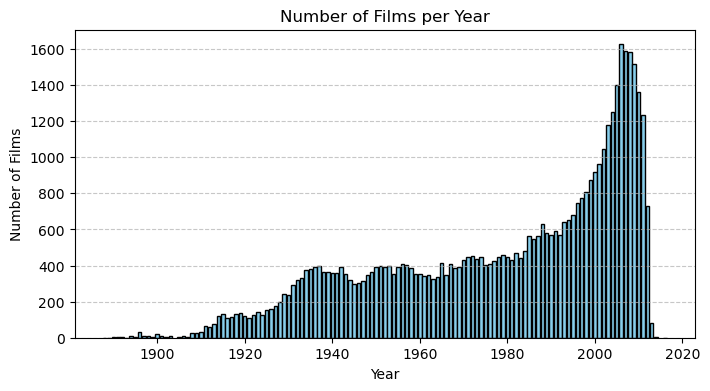

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')) \
                         .reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [13]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1625 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [14]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()

We have also the problem that so far the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys (that come from freebase).

In [15]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and 
# we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list(i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


In [16]:
# Cleaned version of the CMU dataset
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,4.9,57038
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,5.6,42
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,6.1,2911
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,5.9,623
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,6.8,2277
...,...,...,...,...,...,...,...,...,...,...,...,...
49989,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",tt0109922,5.8,972
49990,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,6.2,1588
49991,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],tt1816585,4.6,1711
49992,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,6.8,3203


In [17]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49477 entries, 0 to 49993
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   wikiID          49477 non-null  int64         
 1   freebase_movID  49477 non-null  object        
 2   movie_name      49477 non-null  object        
 3   release_date    49477 non-null  datetime64[ns]
 4   boxoffice       7461 non-null   float64       
 5   runtime         41685 non-null  float64       
 6   language        49477 non-null  object        
 7   country         49477 non-null  object        
 8   genre           49477 non-null  object        
 9   tconst          49477 non-null  object        
 10  averageRating   49477 non-null  float64       
 11  numVotes        49477 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 4.9+ MB


We see here that we have enough data for our analysis.

#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves in the character dataset. To do that let first have a look at the dataset.

In [41]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(cmu_path+'character.metadata.tsv', names=cmu_character_cols)
cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
141599,17848676,/m/047cvy4,2008-10-03,Grandpa,1926-02-11,M,1.854,/m/0cnvdq1,Leslie Nielsen,82.0,/m/0h1rzqv,/m/0h1rzqx,/m/0fb7c
241137,2167778,/m/06rwz6,2005-01,NaN,1942-07-24,M,1.850,/m/038723,Chris Sarandon,NaN,/m/03jpn6f,NaN,/m/021b5
23147,27434686,/m/0b__5xy,1955,NaN,1917-11-24,M,NaN,NaN,John Justin,37.0,/m/0c05h16,NaN,/m/043mbjt
421771,5648156,/m/03bxjkk,1943,Prof. Tojo,1908-05-30,M,NaN,/m/041rx,Mel Blanc,34.0,/m/0hynpg0,/m/0hynpg3,/m/0c5vh
334123,2201333,/m/04j0vm8,1992,NaN,1960-09-12,M,NaN,NaN,Robert John Burke,31.0,/m/0cg3b8y,NaN,/m/0fw0l9


In [42]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          106058 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [43]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)

We will now create a dataset containing the information about the actors and the movies they played in.

In [44]:
actor_movie = cmu_character.drop(columns='release_date', axis=1) \
                           .merge(cmu_movies[['wikiID','averageRating','numVotes','release_date','tconst']],
                                  on='wikiID',how='inner')
actor_movie.head(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,tconst
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,57038,2001-08-24,tt0228333
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,57038,2001-08-24,tt0228333
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,57038,2001-08-24,tt0228333
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,57038,2001-08-24,tt0228333
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,57038,2001-08-24,tt0228333


In [45]:
# We also add the principal actors for each movie
imdb_principals = pd.read_csv(data_path+'name_principals.csv')
imdb_principals.primaryName  = imdb_principals.primaryName.str.lower()
imdb_principals['is_principal'] = 1

actor_movie = actor_movie.merge(imdb_principals,
                                how="left",
                                left_on=['tconst',actor_movie.actor_name.str.lower()],
                                right_on=['tconst','primaryName']).drop(columns=['tconst','primaryName'])
actor_movie['is_principal'].fillna(0, inplace = True)

cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331172,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0
331173,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0
331174,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0
331175,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0


We will now compute a fame score for each actor basing ourselves on the three previous movies he played in to have for every actor a first carreer success indicator. This is subject to change but for the 2nd milestone this first version of the fame score is satisfying (we will show this later on).

Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset to be able later to understand the relation between the character and the actor. 

In [46]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona.sample(5)

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
130432,e25,4276011,Goku Sidestory! The Proof of His Courage Is th...,demon,the demon trying to distract it so Goku and th...,4,48,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...
6888,/m/0dbxfsg,11051069,Sadhna,Champabai,her,5,3,0.00000 0.00000 0.04000 0.49000 0.00000 0.0000...
101514,e0,3032135,Little Big League,mom,his mom,6,12,0.00000 0.16000 0.00000 0.00000 0.00000 0.0000...
122486,e2,36057869,Ettupatti Rasa,pandiyamma,her soft and sensitive sister Pandiyamma,3,12,0.00000 0.03000 0.06000 0.11000 0.00000 0.0000...
134489,e0,4633684,8 Seconds,he,his,5,2,0.00000 0.00000 0.46000 0.00000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those informations about the personas.

In [47]:
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], 
                                    left_on='freebase_char_actor_map', 
                                    right_on='entity_id', how='left').drop(columns='entity_id')

# Print the final dataset
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,persona
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0,NaN
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0,35.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0,NaN
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0,NaN
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331186,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0,NaN
331187,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0,NaN
331188,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0,NaN
331189,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0,NaN


In [48]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331191 entries, 0 to 331190
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331191 non-null  int64         
 1   freebase_movID           331191 non-null  object        
 2   character_name           151500 non-null  object        
 3   actor_birth              255838 non-null  object        
 4   actor_gender             299259 non-null  object        
 5   actor_height             122677 non-null  float64       
 6   actor_ethnicity          80723 non-null   object        
 7   actor_name               330897 non-null  object        
 8   actor_age_at_release     225115 non-null  float64       
 9   freebase_char_actor_map  331191 non-null  object        
 10  freebase_charID          151505 non-null  object        
 11  freebase_actorID         331191 non-null  object        
 12  release_date    

# Fame score computation

First consider the data we have for each movies. We have the number of votes, the rate, the principal actors and also the date of release. One can assume that an actor fame will increase after a good movie and then decrease exponentially while he is not appearing in any other movies. This is the kind of shape we expect for a fame score.

We can first evaluate the instantaneous fame of an actor in a specific movie. It should be related to all the parameters we mentionned. But one can note that the overall number of votes increase with the time so we need to rescale it.

In [49]:
actor_movie.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,is_principal
73224,2259232,/m/06zxw5,NaN,1966-11-06,M,1.854,/m/07hwkr,Peter DeLuise,20.0,/m/0k3hq7,NaN,/m/06l0jw,4.7,4873,1986-11-26,0.0
69831,19032190,/m/09rsjpv,Maj. William Mortamus,1956-03-07,M,1.791,NaN,Bryan Cranston,55.0,/m/09sdgjq,/m/0h2hbb0,/m/05fnl9,5.9,36811,2012-01-20,0.0
35150,896182,/m/03mqpg,NaN,1938-10-30,M,1.880,NaN,Ed Lauter,39.0,/m/0k0b3x,NaN,/m/05p606,6.8,13043,1978-01-01,1.0
307622,133462,/m/0_7w6,Wardrobe,1937-09-06,F,1.727,NaN,Jo Anne Worley,54.0,/m/03js41l,/m/05v3xfv,/m/03yjb_,8.0,473428,1991-11-13,0.0
73336,711102,/m/034vk8,Rina,1971-10-29,F,1.610,/m/041rx,Winona Ryder,14.0,/m/0k07_x,/m/0gxt92_,/m/086sj,6.9,17279,1986-03-28,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

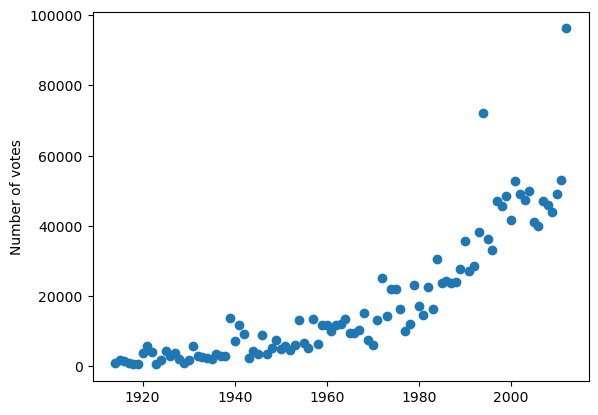

In [50]:
votes_per_year = actor_movie[['release_date','numVotes']].groupby(actor_movie['release_date'].dt.year)[['numVotes']].agg("mean")
plt.scatter(votes_per_year.index,votes_per_year.numVotes)
plt.ylabel('Number of votes')
plt.show

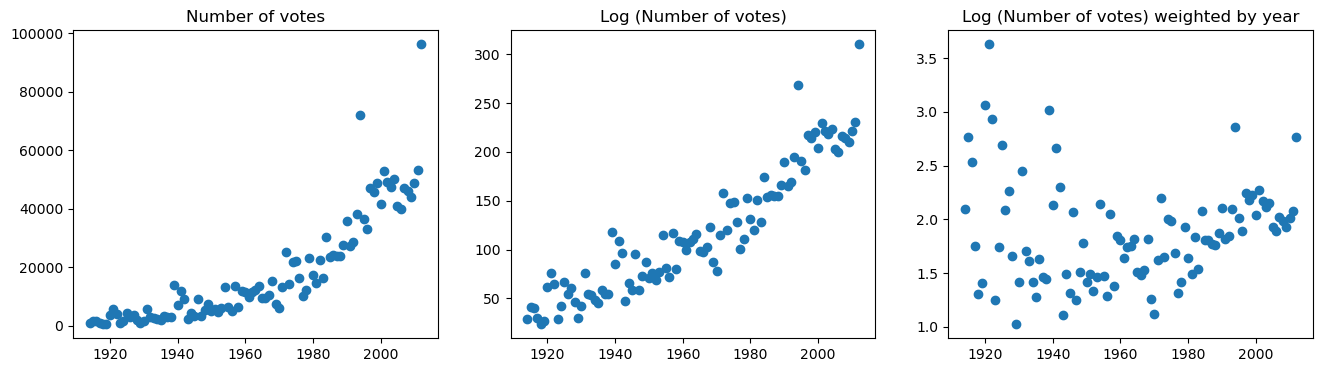

In [51]:
fig, axis = plt.subplots(1,3,figsize=(16,4))

axis[0].scatter(votes_per_year.index,votes_per_year.numVotes)
axis[0].set_title('Number of votes')

axis[1].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes))
axis[1].set_title('Log (Number of votes)')

axis[2].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes)/(votes_per_year.index-1900))
axis[2].set_title('Log (Number of votes) weighted by year')


plt.show()

In [52]:
def instant_fame_score(row,data):
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']
    is_principal = row['is_principal']

    instant_fameScore = rate * np.sqrt(votes) / (year-1900) * (1 + 0.2*is_principal)

    return instant_fameScore

actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie['instant_fameScore'] = actor_movie.apply(lambda x: instant_fame_score(x,actor_movie), axis=1)

In [53]:
def get_fame_score(df, mode='before_after_films'):
    df = df.sort_values('release_date')

    dates = df['release_date'].to_numpy()
    if mode=='filmography':
        # every day between first and last films
        time_range = pd.date_range(dates[0], dates[-1], freq='D').to_list()
    elif mode=='before_after_films':
        # day before and release date of films
        time_range = np.hstack(list(map(lambda d: [d-pd.Timedelta(days=1),d-pd.Timedelta(days=0)], dates)))
    
    # make time_range non decreasing against cases with two films on the same day
    time_range = np.maximum.accumulate(time_range)
    #create a time_range for each films
    time_ranges = np.expand_dims(time_range, axis=0).repeat(axis=0,repeats=len(dates))
    #convert each time range to the number of days from film release date
    day_deltas = np.array(list(map(lambda x : list(map(lambda y,z: (y - dates[z]).days, x[1], [x[0]]*len(time_range))), enumerate(time_ranges))))
    # get exponential for each film
    exps = np.array(list(map(lambda x: np.exp(-x/4/365/5), day_deltas))) # CAN CHANGE DECAY HERE

    # mask exponential part before film release, treated in two cases to deal with films released on the same day issue
    if mode=='filmography':
        exps[exps>1] = 0
    elif mode=='before_after_films':
        idx = np.indices(exps.shape)
        mask = idx[1]<2*idx[0]+1
        exps[mask] = 0
    
    exps = np.diag(df['instant_fameScore'])@exps # CAN CHANGE SCALING HERE

    return time_range, exps.max(axis=0)

def fame_score(df, mode='before_after_films'):
    if mode=='filmography':
        return get_fame_score(df, mode='filmography')
    elif mode=='before_after_films':
        _, fame_scores = get_fame_score(df)
        df['fameScore_before']=fame_scores[2*np.arange(len(fame_scores)//2)]
        df['fameScore_after']=fame_scores[2*np.arange(len(fame_scores)//2)+1]
        return df

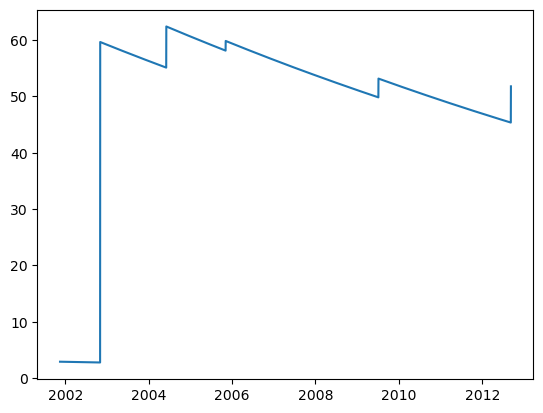

In [70]:
# df=actor_movie.query("freebase_actorID=='/m/010p3'")
df = actor_movie[actor_movie['actor_name']=='Emma Watson']
time_range, sumexps = get_fame_score(df, 'filmography')
plt.plot(time_range, sumexps)
plt.show()

In [55]:
actor_movie = actor_movie.groupby('freebase_actorID').apply(fame_score).reset_index(drop=True)
actor_movie.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,is_principal,instant_fameScore,fameScore_before,fameScore_after
101687,6773693,/m/0gn7yn,NaN,1908-09-13,F,NaN,NaN,Mae Questel,54.0,/m/02vbp_4,NaN,/m/03vjp6,6.3,1019,1962-11-21,0.0,3.243665,3.438813,3.438342
158355,3822458,/m/0b1sv2,Mrs. Helen Schneider,1903-11-07,F,NaN,NaN,Grace Stafford,35.0,/m/0by3lg5,/m/0by3mg8,/m/06kr78,6.7,2087,1939-01-01,0.0,7.848225,0.000000,7.848225
118534,21450904,/m/05fbncw,NaN,1960-05-24,M,1.92,NaN,Doug Jones,37.0,/m/0gw5n_5,NaN,/m/04gv3y,3.9,1136,1998-01-01,0.0,1.341305,23.314351,23.311157
7514,16477359,/m/03y82rh,Mickybo's Ma,1950-02-22,F,1.60,/m/02w7gg,Julie Walters,53.0,/m/04dgbv2,/m/0h35k7x,/m/016nff,7.2,2427,2004-01-01,0.0,3.410626,56.283006,56.275297
90488,584770,/m/02sk8g,NaN,1962,M,NaN,NaN,Kongar-ool Ondar,36.0,/m/0h2p4r6,NaN,/m/03ft5l,7.8,1422,1999-01-01,0.0,2.971045,0.000000,2.971045


In [56]:
actor_movie['fameScore_diff'] = actor_movie['fameScore_after']-actor_movie['fameScore_before']
cmu_character = cmu_character.merge(actor_movie[['freebase_movID','freebase_actorID','fameScore_before','fameScore_after','fameScore_diff']],on=['freebase_movID','freebase_actorID'],how='left')

In [65]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''
    
    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')

    plt.figure(figsize=(10,5))
    for i,film in filmography.iterrows():
        plt.scatter(film.release_date, film.fameScore_after, label=str(i+1)+' : '+film.movie_name,
                    color='cornflowerblue')
        plt.annotate(i+1, xy=(film['release_date'],film['fameScore_after']), xytext=(4,0), textcoords='offset points')
    plt.xlabel('Year')
    plt.ylabel('Fame score')
    plt.title(f'Fame score for {actor_name} along years')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))

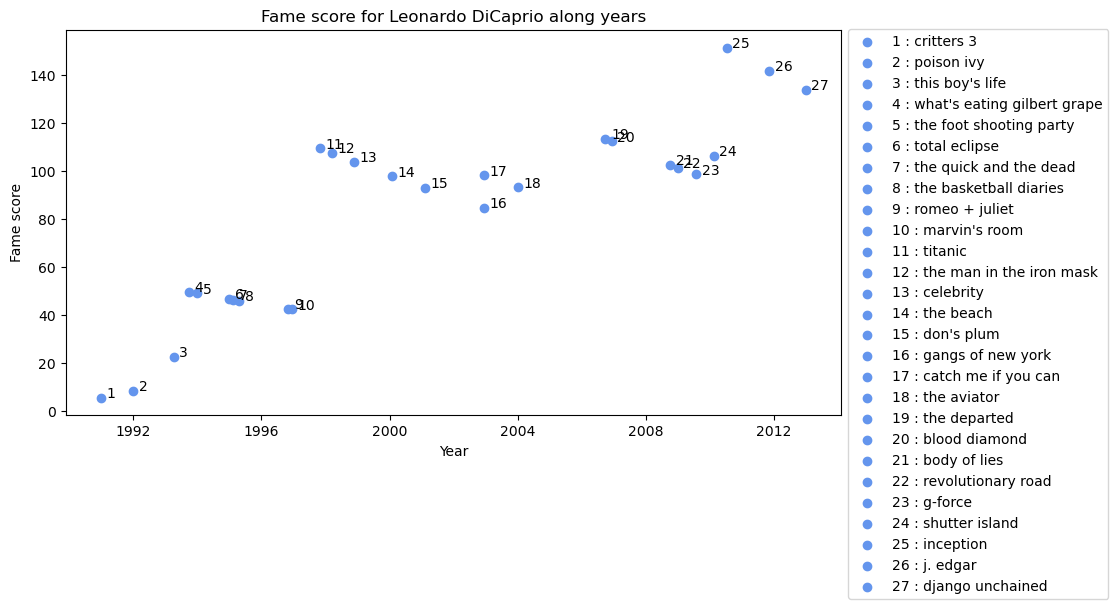

In [68]:
plot_filmography('Leonardo DiCaprio')

## 2. First Data analysis

In the first part we will try to confirm if the fame score is a good indicator of the success of an actor.

Then we will start looking at the impact of different variables on the fame score in order to have a first glimpse at the way to succeed for an actor. This will allow us to assess the relevance of our problematic.

### 2.1 Relation between Box Office, Ratings, and Votes

For the moment we assumed that we could use the ratings as a proxy for the success of a movie. We will now try to see if this assumption is correct (if the ratings are correlated with the box office).

First we clean the cmu_movies to remove rows where either rating or boxoffice is missing.

In [59]:
#Remove rows where both boxoffice and rating are missing
movies_df = cmu_movies.dropna(subset=['boxoffice','averageRating']).copy()

Before doing any analysis we will also adjust the boxoffice to take into account the inflation (i.e., values will be in 2020 dollars)

In [60]:
movies_df["adj_boxoffice"] = movies_df.apply(lambda x: cpi.inflate(x["boxoffice"], x.release_date.year, to=2020), axis=1)

NameError: name 'cpi' is not defined

Let's now plot the boxoffice and the ratings taking into account the number of votes and the year of the movie, to see if there is any noticeable relation between those variables.

In [ ]:
# Divide data into 4 different time periods
periods = [(1901, 1940), (1941, 1980), (1981, 2000), (2001, 2020)]

plt.figure(figsize=(12,9))

# Scatter plot with size based on 'numVotes' and color based on time periods
scatter = plt.scatter(movies_df['averageRating'], movies_df['adj_boxoffice'], 
                      s=movies_df['numVotes']/1000, alpha=0.5, edgecolors='black', 
                      c=np.digitize(movies_df.release_date.dt.year, bins=[period[0] for period in periods[1:]]), 
                      cmap='viridis')


plt.title('Adjusted Box Office vs Rating')
plt.xlabel('Rating')
plt.ylabel('Adjusted Box Office')
plt.yscale('log')

# Create custom legend using legend_elements for sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend = plt.legend(handles, labels, loc="upper left", title="Number of Votes (Ks of votes)", 
                    frameon=True, labelspacing=2)

# Set the edge color of the legend frame
legend.get_frame().set_edgecolor('black')

# Create a colorbar to show time periods
cbar = plt.colorbar(scatter, ticks=np.arange(len(periods)), label='Release Year Period')
cbar.set_ticklabels([f'{start}-{end}' for (start, end) in periods])

plt.show()

From this plot we can derive several informations:

- Films with high number of votes tend to have high ratings and high boxoffice. This is not surprising since the more people watch a movie, the more likely it is to be good and to have a high boxoffice.
- The boxoffice seems to be higher with years.
- Films with low rating tend to have lower number of votes. Is it because people don't watch them based on their low ratings.

We will look at the correlation matrix to have a better understanding at the potential correlation we could find between the variables.

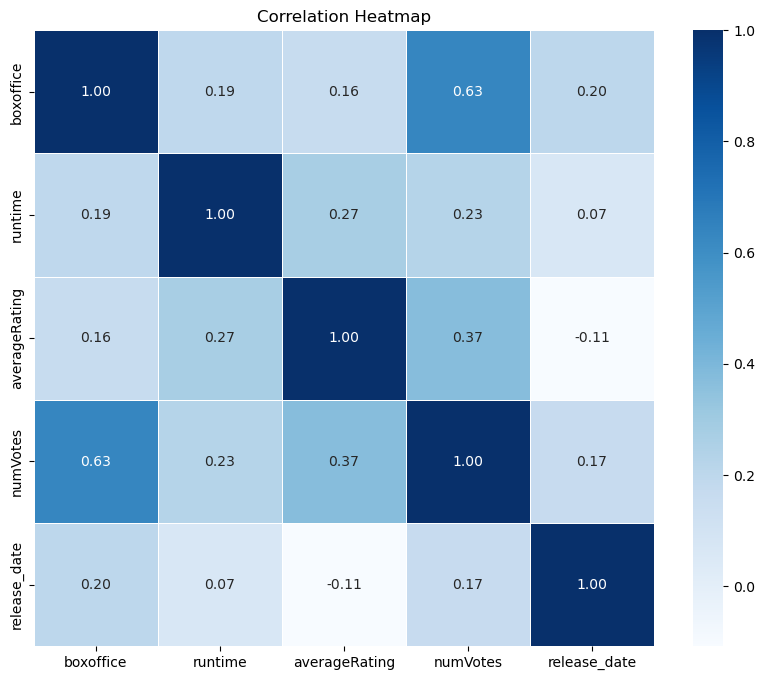

In [61]:
# Calculate the correlation matrix
correlation_matrix = movies_df[['boxoffice', 'runtime', 'averageRating', 'numVotes', 'release_date']]\
                              .corr(method='pearson')

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

This tends to show that the rating and the boxoffice are not correlated. However We have a big correlation between the number of votes, the boxoffice and the rating. 

We confirmed the fact that the more a film is voted the more it tends to have a high rating and a high boxoffice. As we use in the fame score the rating * log(number of votes) we can assume as a first approximation that we capture well the success of a movie an actor plays in and thus the fame of the actor gained thanks to this movie. 

The fact that we explicitly use the rating combined with the number of votes has the effect to give more fame to an actor that plays in "good" movies, movies with high ratings (it is more important for an actor to play in a good movie than in a bad one even if the bad one can sometime bring more money (bigger boxoffice)).

### 2.2 Feats Analysis

We will start by digging into the impact of other actors on your own fame. Casting a movie with a celebrity may bring light on a rising star and contribute to its success. For example, in the plots below, to what extent did Andy Serkis playing Gollum in the Lord of the Rings benefitted in fame from playing with Cate Blanchett, as Galadriel, in that movie knowing that Cate Blanchett has a fame score among the 100 best ones in previous years.

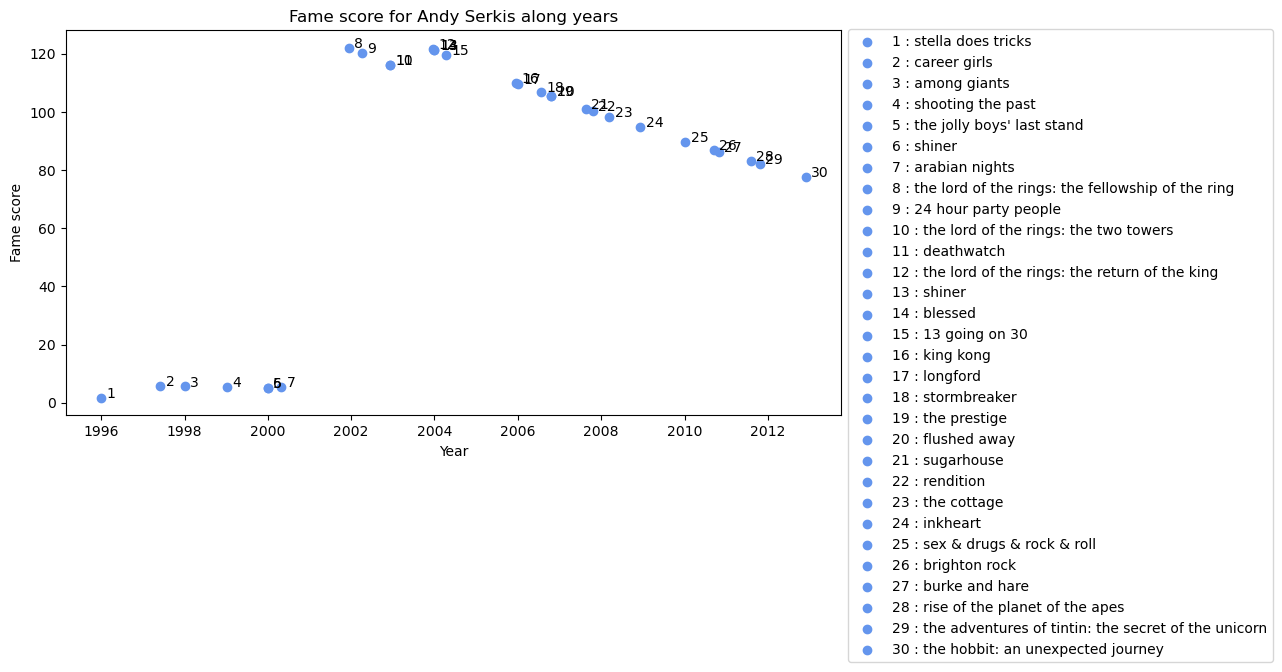

In [66]:
plot_filmography('Andy Serkis')

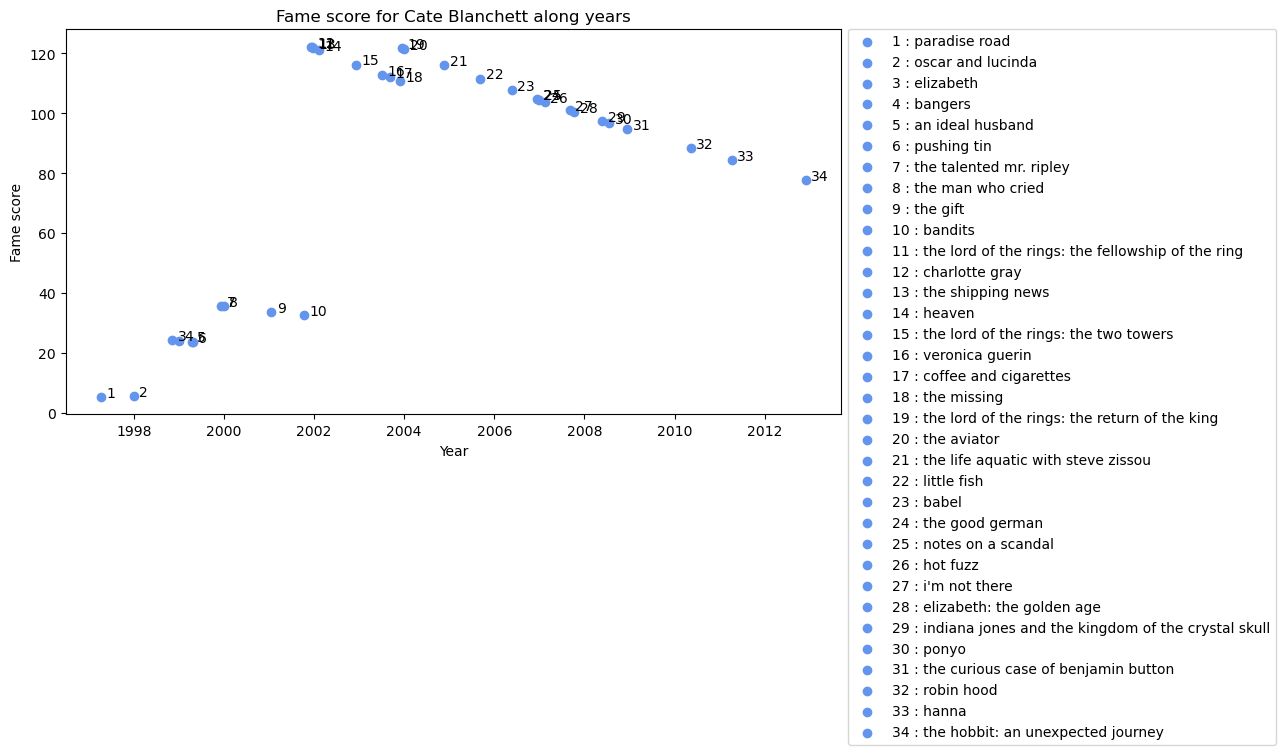

In [67]:
plot_filmography('Cate Blanchett')

We can see their that when Andy Serkis plays with Cate Blanchett, his fame score is higher than when he plays with other actors. This is a first indication that the fame of an actor may be impacted by the fame of the other actors he plays with.

Let's compute for each year the 100 most famous actresses and actors, that we think may be carreer or fame boosters for their colleagues.

In [64]:
def get_top100_actor(df):
    '''
    This function returns the top 100 actors with the highest fame score for each year
    '''

    # drop duplicates in case actor has several films in same year, keep the best fameScore attained that year
    df=df.sort_values(['freebase_actorID','fameScore']).drop_duplicates(subset='freebase_actorID', keep='last') 
    return df.iloc[np.argsort(df.fameScore.values)[-100:],:]

top100_actor_year=cmu_character.groupby(cmu_character.release_date.dt.year)[['wikiID','actor_name',
                                                                             'freebase_actorID','fameScore']] \
                               .apply(get_top100_actor) \
                               .reset_index(level=0)
top100_actor_year.sample(5)

KeyError: "Columns not found: 'fameScore'"

As we are interested in fame increases or decreases, we compute the fame's difference before and after portraying in a film. The fame score is computed using at most 3 past films, we then filter out the first 3 values to keep meaningful variations.

We now want to create a table of featurings, where we will have for each actor an entry corresponding to an actor he/she played with in order to know the different connection between actors we have over the years.

In [ ]:
# Create dataframe actor_feats linking an actor 1 benefitting from casting with an actor 2 
# (reverse relation is also present in dataframe)
actor_feats = cmu_character[['wikiID','actor_name','freebase_actorID','release_date']]
actor_feats = actor_feats.merge(actor_feats, on=['wikiID','release_date'])
actor_feats.columns = ['wikiID','actor_name_1','freebase_actorID_1','release_date',
                       'actor_name_2','freebase_actorID_2']

# Remove feats with itself
actor_feats = actor_feats[actor_feats.freebase_actorID_1!=actor_feats.freebase_actorID_2]
actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2
2981387,25920477,Craig Thomas,/m/0g41d4h,2011-03-11,Kyle Gatehouse,/m/0bv6kyv
1831489,26608129,NaN,/m/049ggb,2010-05-15,Stuart McQuarrie,/m/02vmysx
678377,5766046,Michael Dorn,/m/01s54v,2003-06-21,Tony Burton,/m/0bxvvc
400580,2549266,Samuel L. Jackson,/m/0f5xn,2010-08-02,Mark Wahlberg,/m/0gy6z9
1170793,2763180,Jeff Garlin,/m/04pz5c,2005-12-21,Michelle Arthur,/m/0ks_tf


We need now to retrieve the fame score variation for the actor1 corresponding to the collaboration he/she made with the actor2.

In [ ]:
# Merge on actor 1 in the feats with actor_fame_diff to get its fame variations
actor_feats = actor_feats.merge(actor_fame_diff, left_on=['wikiID','freebase_actorID_1','release_date'], 
                                right_on=['wikiID','freebase_actorID','release_date']) \
                         .drop(columns='freebase_actorID', axis=1)
actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,fameScore_diff
732481,2862798,Larenz Tate,/m/0337vz,1998-08-28,Ben Vereen,/m/01f6nq,-0.058194
861709,15656621,Liza Lapira,/m/02qxkld,2009-03-12,Holly Weber,/m/02z0pgd,0.114658
614285,15763775,Gene Tierney,/m/018sgr,1942-03-20,Henry Fonda,/m/0cj8x,-0.029863
878372,20692991,Keira Knightley,/m/01l2fn,2010-09-18,Cheryl Ann Leaser,/m/0glhdf3,0.032222
1475957,20903233,Mohan Choti,/m/0cr7q2b,1975-01-01,Moushumi Chatterjee,/m/0k1rsd,-0.011299


We now want to have the information on is the feat a feat with a "famous" actor (corresponding to our criteria it is the top100 famous actor of each year). 

In [ ]:
# Apply a left join on actor_feats with the top100 actors on actor 2 of actor_feats as it is the one 
# from which actor 1 benefits. Left join allows to put NaNs when no match indicating that this feat 
# between actors does not contain a famous ones
actor_feats = actor_feats.merge(top100_actor_year[['wikiID','freebase_actorID']], \
                                left_on=['wikiID','freebase_actorID_2'], \
                                right_on=['wikiID','freebase_actorID'], how='left') \
                         .rename(columns={'freebase_actorID':'with_top100'})
actor_feats['with_top100'] = ~actor_feats['with_top100'].isna()

actor_feats.sample(5)

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,fameScore_diff,with_top100
899791,1166096,Jude Law,/m/01r93l,2006-09-21,Jackie Earle Haley,/m/01lxl6,-0.026023,False
1507310,2003410,George Kennedy,/m/02wrrm,1965-01-01,James Stewart,/m/044qx,-0.088133,False
941583,2500472,Walter Brooke,/m/02p8shk,1977-02-09,Mary Jackson,/m/07kskd,0.087349,False
703255,414180,Jack Nicholson,/m/09fb5,2003-12-12,Frances McDormand,/m/01p7yb,0.009464,False
717648,1996624,Gregory Peck,/m/0k9j_,1991-01-01,Bette Henritze,/m/0bgbp45,0.046943,False


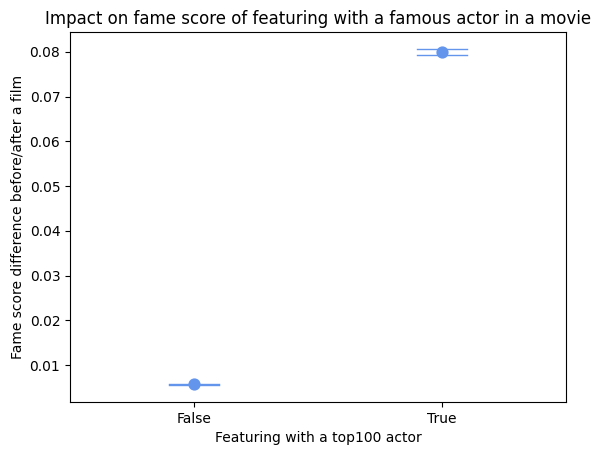

In [ ]:
sns.pointplot(data=actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              err_kws={'linewidth': 1}, linestyles='none', capsize=0.2)
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [ ]:
stats.ttest_ind(actor_feats.query('with_top100==True')['fameScore_diff'].values, 
                actor_feats.query('with_top100==False')['fameScore_diff'].values)

TtestResult(statistic=213.65852137855367, pvalue=0.0, df=1637357.0)

The group of actors featuring with famous actors has a higher fame increase mean than the other one. 

The confidence intervals are not overlapping meaning that the null hypothesis stating that "Portraying in a film with a celebrity does not improve your fame score" can be rejected. This is confirmed through a t-test between their means yielding a p-value of 0.

These results motivate further analysis of what relations between actors influence the fame score evolution. Moreover, matching probably should be used as to compare group that are comparable, mitigating effects of confounders. Indeed, it could be that mostly already rising actors play with famous ones, to not hire only celebrities weighting more on the budget...

### 2.2 Past genres Analysis

Here, we would like to study the relation between the number of genres an actor played in and its fame score

In [ ]:
def get_genre_diversity(df):
    '''
    This function returns the number of different past different genres assigned to movies an actor 
    played in before.
    '''
    df = df.sort_values('release_date')
    return pd.DataFrame({'wikiID':df['wikiID'].values,
                         'genre_diversity':[len(np.unique(np.hstack(df.iloc[:i+1]['genre'].values)))
                                            for i in range(df.shape[0])]})

# compute a dataframe with actor informations for each film with fame and number of past genres
actor_genres = cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date']] \
                            .merge(cmu_movies[['wikiID','genre']])

actor_genres['genre'] = actor_genres['genre'].apply(lambda x : x[:3]) #keep only the 3 main genres

actor_genres = actor_genres.merge(actor_genres.groupby('freebase_actorID').apply(get_genre_diversity)\
                                                                          .reset_index(level=0),
                                  on=['freebase_actorID','wikiID'])
actor_genres.sample(5)

,wikiID,actor_name,freebase_actorID,fameScore,release_date,genre,genre_diversity
48223,1045986,Annabella Sciorra,/m/0338ws,0.546209,1997-08-15,"[Thriller, Crime Fiction, Drama]",25
194506,24225564,Robert Lowery,/m/07zb2b,0.632975,1942-12-18,"[Action/Adventure, Western, Action]",11
20516,3737168,Peter Butterworth,/m/030r7t,0.189535,1965-01-01,"[Parody, Western, Comedy Western]",3
44312,3257956,Paul Mazursky,/m/020x5r,0.474306,1996-01-01,"[Crime Fiction, Black comedy, Drama]",16
324015,28360586,Atle Merton,/m/0gct1w6,0.173068,1955-01-01,"[Romance Film, Drama]",2


Let's now use a scatter plot between the genre diversity and the fame score, adding the best fitting line.

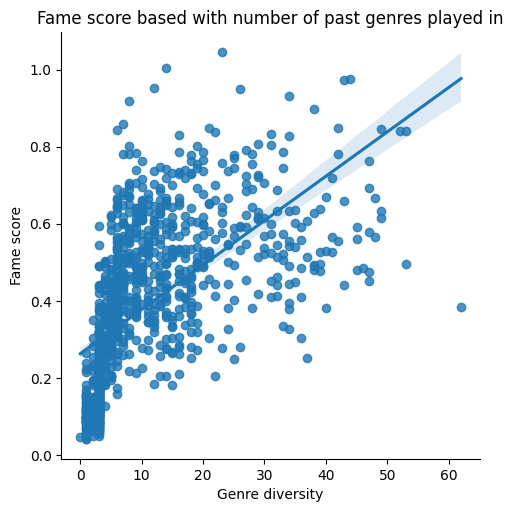

In [ ]:
# we use a sample from the dataframe for clarity purposes
sns.lmplot(data=actor_genres.sample(1000), x='genre_diversity', y='fameScore')
plt.title('Fame score based with number of past genres played in')
plt.xlabel('Genre diversity')
plt.ylabel('Fame score')
plt.show()

We can now compute a linear regression model to see if there is a significant relation between the genre diversity and the fame score.

In [ ]:
mod = smf.ols(formula='fameScore ~ genre_diversity', data=actor_genres)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              fameScore   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.841e+05
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:45:59   Log-Likelihood:             1.2459e+05
No. Observations:              331169   AIC:                        -2.492e+05
Df Residuals:                  331167   BIC:                        -2.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2579      0.000    6

Using statsmodels package we fit a line to the data and find a coefficient of 0.0119 for the genre diversity with a p-value rejecting the null hypothesis. This motivates further analysis to assess wether or not we only observe a correlation rather than a causation. In case of causality, it would mean that the actor should play in a broad genre of movies to maximize its fame score.

### 2.2 Persona Analysis

The goal in this part is to obtain the relation between actor characteristics, the kind of characters they play (persona) and the fame score increase or decrease. To do that we first only select in the table the rows with full usefull data for this analysis and we look at the distribution of the fame score difference.

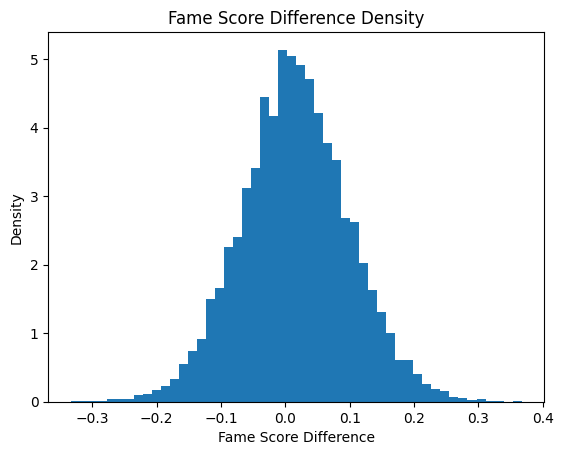

In [ ]:
# We retrieve the fame score difference for each actor at every film
cmu_chara_persona = cmu_character.merge(actor_fame_diff,on=['wikiID','freebase_actorID','release_date'])
cmu_chara_persona = cmu_chara_persona[['actor_gender','actor_height','actor_ethnicity','actor_age_at_release',
                                       'persona','fameScore_diff']].copy()
cmu_chara_persona.dropna(inplace=True)

#We transform the persona dtype to str because we don't want to interpret it as numbers but as a class name
cmu_chara_persona['persona'] = cmu_chara_persona['persona'].apply(lambda x : str(int(x)))

plt.hist(cmu_chara_persona['fameScore_diff'],density=True,bins=50)
plt.title('Fame Score Difference Density')
plt.xlabel('Fame Score Difference')
plt.ylabel('Density')
plt.show()

We can see that we have in average a little increase in fame when an actor appears in a movie, which makes sense.

Now we want to look at how the personas and ethnicity are distributed among the actors. If we see that we have personas or ethnicity that are not present enough we will get rid of them since they will not be significant enough for our analysis.

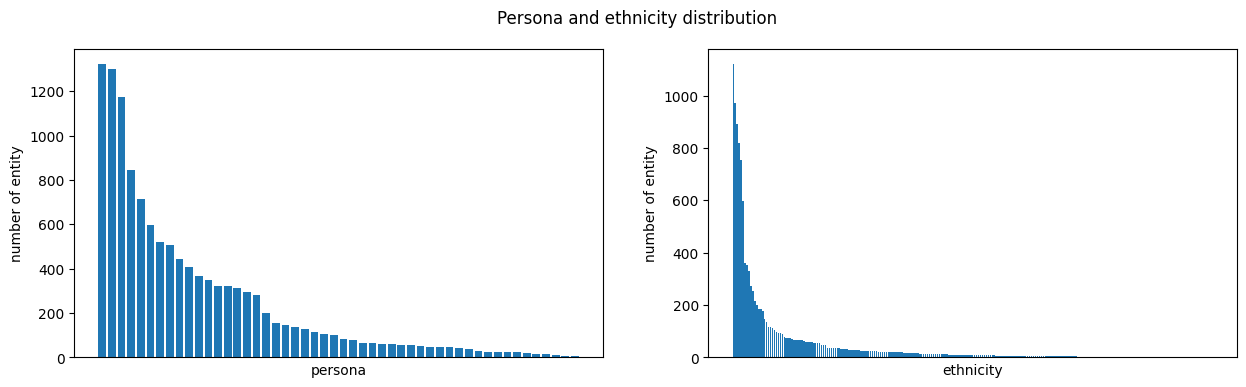

In [ ]:
persona_count = cmu_chara_persona[['persona','actor_ethnicity']]\
                .groupby('persona',as_index=False).count().rename(columns={'actor_ethnicity':'count'})
persona_count.sort_values('count',inplace=True,ascending=False)

ethnicity_count = cmu_chara_persona[['persona','actor_ethnicity']]\
                  .groupby('actor_ethnicity',as_index=False).count().rename(columns={'persona':'count'})
ethnicity_count.sort_values('count',inplace=True,ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Persona and ethnicity distribution')

axes[0].bar(persona_count['persona'],persona_count['count'])
axes[1].bar(ethnicity_count['actor_ethnicity'],ethnicity_count['count'])

for ax in axes:
    ax.set_xticks([])

axes[0].set_xlabel('persona')
axes[1].set_xlabel('ethnicity')
axes[0].set_ylabel('number of entity')
axes[1].set_ylabel('number of entity');

In [ ]:
# We decide to take only the ones with more than 200 entities
persona_count = persona_count.query('count >= 200')
ethnicity_count = ethnicity_count.query('count >= 200')

# We keep only the rows with persona and the ethnicity we're interested in 
cmu_chara_persona = cmu_chara_persona.merge(persona_count['persona'],on='persona',how='right')
cmu_chara_persona = cmu_chara_persona.merge(ethnicity_count['actor_ethnicity'],on='actor_ethnicity',how='right')

cmu_chara_persona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6071 entries, 0 to 6070
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   actor_gender          6071 non-null   object 
 1   actor_height          6071 non-null   float64
 2   actor_ethnicity       6071 non-null   object 
 3   actor_age_at_release  6071 non-null   float64
 4   persona               6071 non-null   object 
 5   fameScore_diff        6071 non-null   float64
dtypes: float64(3), object(3)
memory usage: 284.7+ KB


For the further analysis, the '/' in the actor_ethnicity id will cause problem to the algorithm. We decide to change them to a code_number here.

In [ ]:
ethnicity_code_nbr = ethnicity_count['actor_ethnicity'].reset_index(drop=True)\
                                                        .reset_index().rename(columns={'index':'ethni_nbr'})

cmu_chara_persona = cmu_chara_persona.merge(ethnicity_code_nbr,on='actor_ethnicity')\
                                     .drop(columns='actor_ethnicity')
cmu_chara_persona.sample(5)

,actor_gender,actor_height,actor_age_at_release,persona,fameScore_diff,ethni_nbr
1809,F,1.70,26.0,49,0.034333,2
5818,M,1.80,45.0,34,-0.033053,11
5957,M,1.78,40.0,35,0.131316,12
1351,M,1.80,25.0,34,0.110052,1
1750,M,1.73,16.0,49,0.087032,2


We can now separate the categorical values with the get_dummies function. This correspond to a one hot encoding of the categorical values.

In [ ]:
cmu_chara_persona_analysis = pd.get_dummies(cmu_chara_persona,columns=['persona','actor_gender','ethni_nbr'])

Finally we can perform a linear regression to assess the impact of each actor characteristic on the fame score difference.

In [ ]:
# This code is used to define the formula for the regression
columns = cmu_chara_persona_analysis.columns.tolist()[3:]
formula = 'fameScore_diff ~ actor_age_at_release + actor_height'

for col in columns:
    formula += ' + C('+col+')'

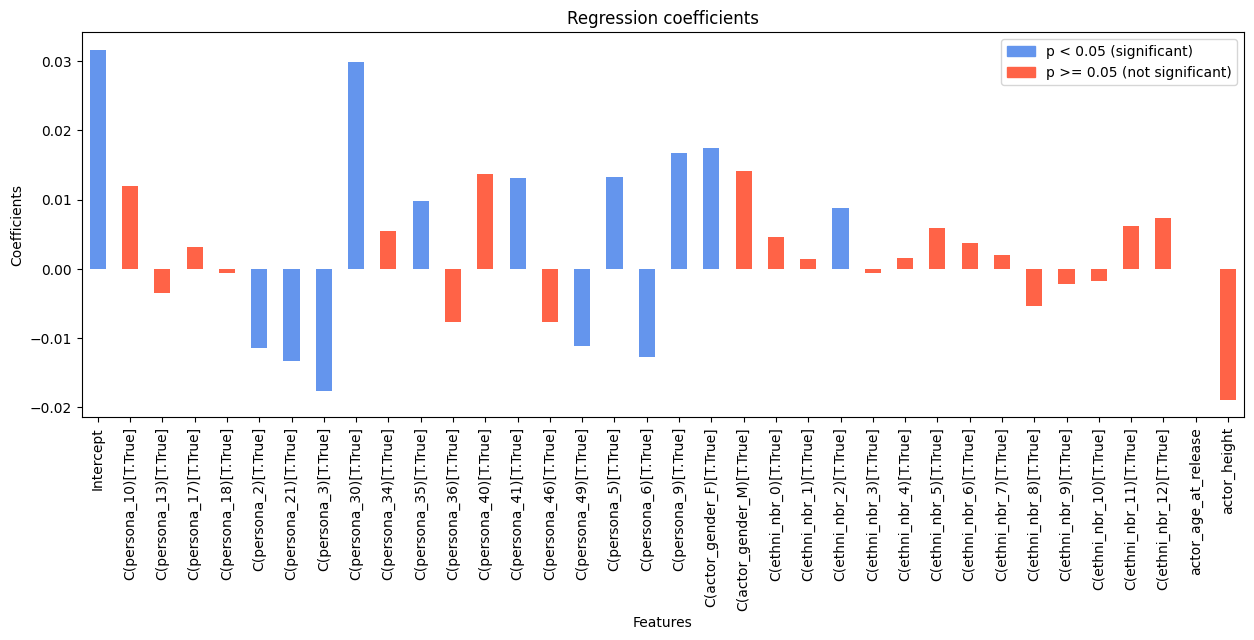

In [ ]:
mod = smf.ols(formula=formula, data=cmu_chara_persona_analysis)
res = mod.fit()

colors = ['cornflowerblue' if p < 0.05 else 'tomato' for p in res.pvalues]

res.params.plot.bar(figsize=(15,5) ,color=colors)

significant_patch = mpatches.Patch(color='cornflowerblue', label='p < 0.05 (significant)')
not_significant_patch = mpatches.Patch(color='tomato', label='p >= 0.05 (not significant)')
plt.legend(handles=[significant_patch, not_significant_patch])

plt.title('Regression coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

In [ ]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         fameScore_diff   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.688
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           1.21e-11
Time:                        22:46:00   Log-Likelihood:                 6508.8
No. Observations:                6071   AIC:                        -1.295e+04
Df Residuals:                    6038   BIC:                        -1.273e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

When conducting linear analysis, it is essentially comparing means of different groups represented by the categorical variables. Hence, we see that the average fame score increase greatly varies depending on the actor's characteristics and persona played. However, we observe that many of these variables have a coefficient for which we cannot reject the null hypothesis under the 0.05 threshold. We will further analyse to better differentiate subgroups in which the fame score increase is significantly different.